In [1]:
import pandas as pd
import numpy as np 
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import nltk
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import preprocess_string
# Read in the data
# df = pd.read_csv('dataset/full_dataset.csv')

## Clustering wrt to Ingredients

In [3]:
df.head(5)

,Unnamed: 0,title,ingredients,directions,link,source,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."


In [4]:
import torch
import pandas as pd
import torchtext
from torchtext.data.utils import get_tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [5]:
# Create a TfidfVectorizer object to convert the ingredients into a feature matrix
vectorizer = TfidfVectorizer(stop_words="english")

df_sample = df.head(100000)

# Create a feature matrix
X = vectorizer.fit_transform(df_sample['ingredients'])

In [6]:
X.shape

(100000, 6608)

In [7]:
vectorizer.get_feature_names_out()

array(['000', '07', '0z', ..., 'zucchinis', 'zuke', 'zwieback'],
      dtype=object)

In [8]:
from sklearn.metrics import silhouette_score

cluster_sizes = range(2, 10)
silhouette_scores = []

for size in cluster_sizes:
    kmeans = KMeans(n_clusters=size, random_state=0).fit(X)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

/Users/aybarsyazici/Documents/GenAI/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KeyboardInterrupt: 

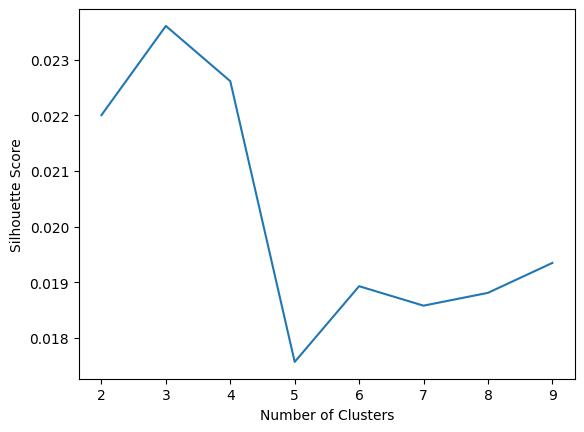

In [ ]:
import matplotlib.pyplot as plt

plt.plot(cluster_sizes, silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [ ]:
# get the most optimal number of clusters
optimal_num_clusters = cluster_sizes[np.argmax(silhouette_scores)]
# cluster the data
kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=0).fit(X)
# assign the labels to df_sample
df_sample['cluster'] = kmeans.labels_

/Users/aybarsyazici/Documents/GenAI/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/jt/f2yqrnv562q34hfjkkskqwzw0000gn/T/ipykernel_853/3439224054.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['cluster'] = kmeans.labels_


In [ ]:
# print some recipes from each cluster
for i in range(optimal_num_clusters):
    print(f"Cluster {i}")
    display(df_sample[df_sample['cluster'] == i]['ingredients'].head(5))
    print()

Cluster 0


1    ["1 small jar chipped beef, cut up", "4 boned ...
2    ["2 (16 oz.) pkg. frozen corn", "1 (8 oz.) pkg...
3    ["1 large whole chicken", "2 (10 1/2 oz.) cans...
5    ["6 baking potatoes", "1 lb. of extra lean gro...
8    ["1 1/2 lb. round steak (1-inch thick), cut in...
Name: ingredients, dtype: object


Cluster 1


6     ["1 1/2 c. sugar", "1/2 c. butter", "1 egg", "...
19    ["3/4 c. sugar", "1/2 c. shortening", "1 1/2 c...
20    ["1 c. sugar", "1/2 c. shortening", "2 eggs (a...
41    ["3 Tbsp. softened butter or margarine", "1/2 ...
42    ["5 c. flour", "3 Tbsp. sugar", "4 tsp. baking...
Name: ingredients, dtype: object


Cluster 2


0     ["1 c. firmly packed brown sugar", "1/2 c. eva...
4     ["1 c. peanut butter", "3/4 c. graham cracker ...
7     ["1 can cream-style corn", "1 can whole kernel...
9     ["1 large container Cool Whip", "1 large can c...
10    ["1 (17 oz.) can dark sweet pitted cherries", ...
Name: ingredients, dtype: object

## Association Rule Mining

In [3]:
def encode_directions():
    # Load the dataset
    df_sample2 = pd.read_csv('dataset/full_dataset.csv')

    # Convert the ingredients column to a list of lists
    transactions = df_sample2['directions'].to_numpy().tolist()
    transactions = [eval(x) for x in transactions]

    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

    transactions_word_scale = []
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

    for transaction in transactions:
        recipe = []
        for sentence in transaction:
            # remove stop words and tokenize
            tokens = tokenizer.tokenize(sentence)
            # convert to lowercase, remove punctuation, and remove stop words
            tokens = [word.lower() for word in tokens if word.isalpha() and not word in stop_words]
            recipe += tokens
        transactions_word_scale.append(recipe)

    # Create a TransactionEncoder object to convert the list of lists into a one-hot encoded matrix
    te = TransactionEncoder()
    transactions_one_hot = te.fit(transactions_word_scale).transform(transactions_word_scale, sparse=True)
    # te_ary_word_scale = te.transform(transactions_word_scale)
    df_word_scale = pd.DataFrame.sparse.from_spmatrix(transactions_one_hot, columns=te.columns_)

    return df_sample2, df_word_scale

In [4]:
# # Since the kernel crashes trying to transform all of the data,
# # We do it in batches of 10000
# from tqdm.notebook import tqdm

# batch_size = 10000
# num_batches = len(transactions_word_scale) // batch_size + 1
# transactions_one_hot = []
# for batch in tqdm(range(num_batches)):
#     print(f"Batch {batch + 1} of {num_batches}")
#     transactions_one_hot += te.transform(transactions_word_scale[batch * batch_size:(batch + 1) * batch_size], sparse=True)

In [5]:
# Apply the Apriori or fpgrowth algorithm to the one-hot encoded matrix to extract frequent itemsets
# frequent_itemsets = fpgrowth(df_sentence_scale, min_support=0.01, use_colnames=True, max_len=5)

# frequent_itemsets.sort_values(by='support', ascending=False).head(10)

In [6]:
import os
# check if frequent_itemsets.pkl exists
if os.path.isfile('dataset/frequent_itemsets_word_preprocessed.pkl'):
    print('Loading frequent_itemsets_word.pkl')
    frequent_itemsets_word = pd.read_pickle('dataset/frequent_itemsets_word_preprocessed.pkl')
else:
    print('Creating frequent_itemsets_word_preprocessed.pkl')
    df_sample2, df_word_scale = encode_directions()
    frequent_itemsets_word = fpgrowth(df_word_scale, min_support=0.01, use_colnames=True, max_len=5)
    frequent_itemsets_word.to_pickle('dataset/frequent_itemsets_word_preprocessed.pkl')

Loading frequent_itemsets_word.pkl


In [7]:
display(frequent_itemsets_word.sort_values(by='support', ascending=True).head(10))

frequent_itemsets_word.sort_values(by='support', ascending=False).head(10)

,support,itemsets
893441,0.01,"(pan, bowl, medium, add, degre)"
1044253,0.01,"(saut, onion, bake, stir)"
1044094,0.01,"(saut, minut, stir, pepper, sauc)"
123929,0.01,"(add, water, hour, sugar, combin)"
719279,0.01,"(sheet, butter, vanilla, salt)"
1041963,0.01,"(oven, cool, preheat, bake, wrap)"
576657,0.01,"(oven, remov, cook, serv, sauc)"
721079,0.01,"(brown, sheet, sprinkl, place)"
1040777,0.01,"(flour, egg, edg, salt)"
1039809,0.01,"(pan, butter, bake, edg)"


,support,itemsets
0,0.601769,(minut)
70,0.585925,(add)
1,0.443156,(mix)
27,0.431825,(bake)
286098,0.388694,"(add, minut)"
38,0.381686,(serv)
2,0.380475,(stir)
39,0.369445,(cook)
3,0.368158,(heat)
71,0.362760,(salt)


In [8]:
# Apply association rule mining to extract rules between frequent itemsets
rules = association_rules(frequent_itemsets_word, metric="lift", min_threshold=2)

# Print the top 5 rules by lift
display(rules.sort_values(by="lift", ascending=False).head(5))

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
14659663,(yeast),"(rise, flour)",0.015674,0.013480,0.010266,0.654943,48.587534,0.010054,2.859004,0.995014
14659658,"(rise, flour)",(yeast),0.013480,0.015674,0.010266,0.761563,48.587534,0.010054,4.128239,0.992801
12187170,"(preheat, bake, food)","(oven, processor)",0.013981,0.016442,0.010898,0.779509,47.410179,0.010669,4.460761,0.992788
12187173,"(oven, processor)","(preheat, bake, food)",0.016442,0.013981,0.010898,0.662850,47.410179,0.010669,2.924573,0.995272
12187167,"(oven, bake, processor)","(preheat, food)",0.014149,0.016257,0.010898,0.770274,47.380624,0.010668,4.282239,0.992943


In [9]:
rules[rules.lift >= 2].shape

(17969340, 10)

In [10]:
# save rules to csv
rules.to_csv('dataset/rules_recipe_scale.csv', index=False)

### Confidence

> The confidence of a rule A->C is the probability of seeing the consequent in a transaction given that it also contains the antecedent. Note that the metric is not symmetric or directed; for instance, the confidence for A->C is different than the confidence for C->A. The confidence is 1 (maximal) for a rule A->C if the consequent and antecedent always occur together. 

### Leverage

> Leverage computes the difference between the observed frequency of A and C appearing together and the frequency that would be expected if A and C were independent. A leverage value of 0 indicates independence.

### Lift

> The lift metric is commonly used to measure how much more often the antecedent and consequent of a rule A->C occur together than we would expect if they were statistically independent. If A and C are independent, the Lift score will be exactly 1.

> A lift score greater than 1 indicates a positive association, meaning that the occurrence of one item increases the likelihood of the occurrence of the other item. A lift score less than 1 indicates a negative association, meaning that the occurrence of one item decreases the likelihood of the occurrence of the other item.




// Evaluatıon ıdea:
Top rules wıth confıdence.

Each recıpe. for each whıch are the top 10. 
To compare metrıcs

Compare dırectly to the other 

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
# Create a network graph of the association rules

# Only consider rules with lift greater than X
filtered_rules = rules[rules.lift >= 1.5]

G = nx.DiGraph()
for i in range(len(filtered_rules)):
    # add edge with an arrow from antecedents to consequents
    G.add_edge(filtered_rules.iloc[i]['antecedents'], filtered_rules.iloc[i]['consequents'], weight=filtered_rules.iloc[i]['lift'])

# make the graph bigger
plt.figure(figsize=(25, 20))
# Draw the network graph
pos = nx.spring_layout(G, k=0.5)
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color="cyan")
nx.draw_networkx_edges(G, pos, width=2, edge_color="gray", arrowsize=20)
nx.draw_networkx_labels(G, pos, font_size=8, font_family="Monaco")
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{w:.2f}" for u, v, w in G.edges(data="weight")})
plt.axis("off")
plt.show()

In [ ]:
# Apply page rank to the network graph
page_rank = nx.pagerank(G)
# Sort the recipes by page rank
sorted(page_rank.items(), key=lambda x: x[1], reverse=True)[:25]

[(frozenset({'heat'}), 0.07877337476210453),
 (frozenset({'bake'}), 0.05557310158558549),
 (frozenset({'oven'}), 0.038029025965498696),
 (frozenset({'salt'}), 0.03774117243315542),
 (frozenset({'cook'}), 0.0308067804548631),
 (frozenset({'medium'}), 0.028190423348336425),
 (frozenset({'add', 'heat'}), 0.020288495595661926),
 (frozenset({'pepper'}), 0.019545145388653148),
 (frozenset({'heat', 'minutes'}), 0.018800310023945624),
 (frozenset({'bowl'}), 0.01858164735848401),
 (frozenset({'large'}), 0.017905427539112794),
 (frozenset({'oil'}), 0.016471199746011814),
 (frozenset({'add', 'minutes'}), 0.01504192262865065),
 (frozenset({'preheat'}), 0.01497225672256439),
 (frozenset({'bake', 'minutes'}), 0.014746403755527972),
 (frozenset({'minutes', 'oven'}), 0.013689104918381078),
 (frozenset({'stir'}), 0.013031863386856041),
 (frozenset({'baking'}), 0.012996025942646289),
 (frozenset({'minutes', 'salt'}), 0.0127230985793782),
 (frozenset({'minutes'}), 0.012209597089456794),
 (frozenset({'add

In [ ]:
# Save to a file the neighbors and weights of the top 5 recipes by page rank
with open('dataset/rules_extracted.txt', 'w') as f:
    for recipe in sorted(page_rank.items(), key=lambda x: x[1], reverse=True)[:5]:
        f.write(f"Recipe: {recipe[0]}\n")
        # Find the most important 5 neighbors of the recipe
        neighbors = sorted(G[recipe[0]].items(), key=lambda x: x[1]['weight'], reverse=True)[:5]
        # Combine the sets of all neighbors into one list sorted by weight
        all_neighbors = sorted([(neighbor[0], neighbor[1]['weight']) for neighbor in neighbors], key=lambda x: x[1], reverse=True)
        # Eliminate weights
        all_neighbors = [neighbor[0] for neighbor in all_neighbors]
        # Combine all sets into one set
        new_all_neighbors = set()
        for neighbor in all_neighbors:
            new_all_neighbors = new_all_neighbors.union(neighbor)
        # Write to a file
        f.write(f"Neighbors: {new_all_neighbors}\n")
        f.write('\n')

In [13]:
from nx_draw_helper import my_draw_networkx_edge_labels

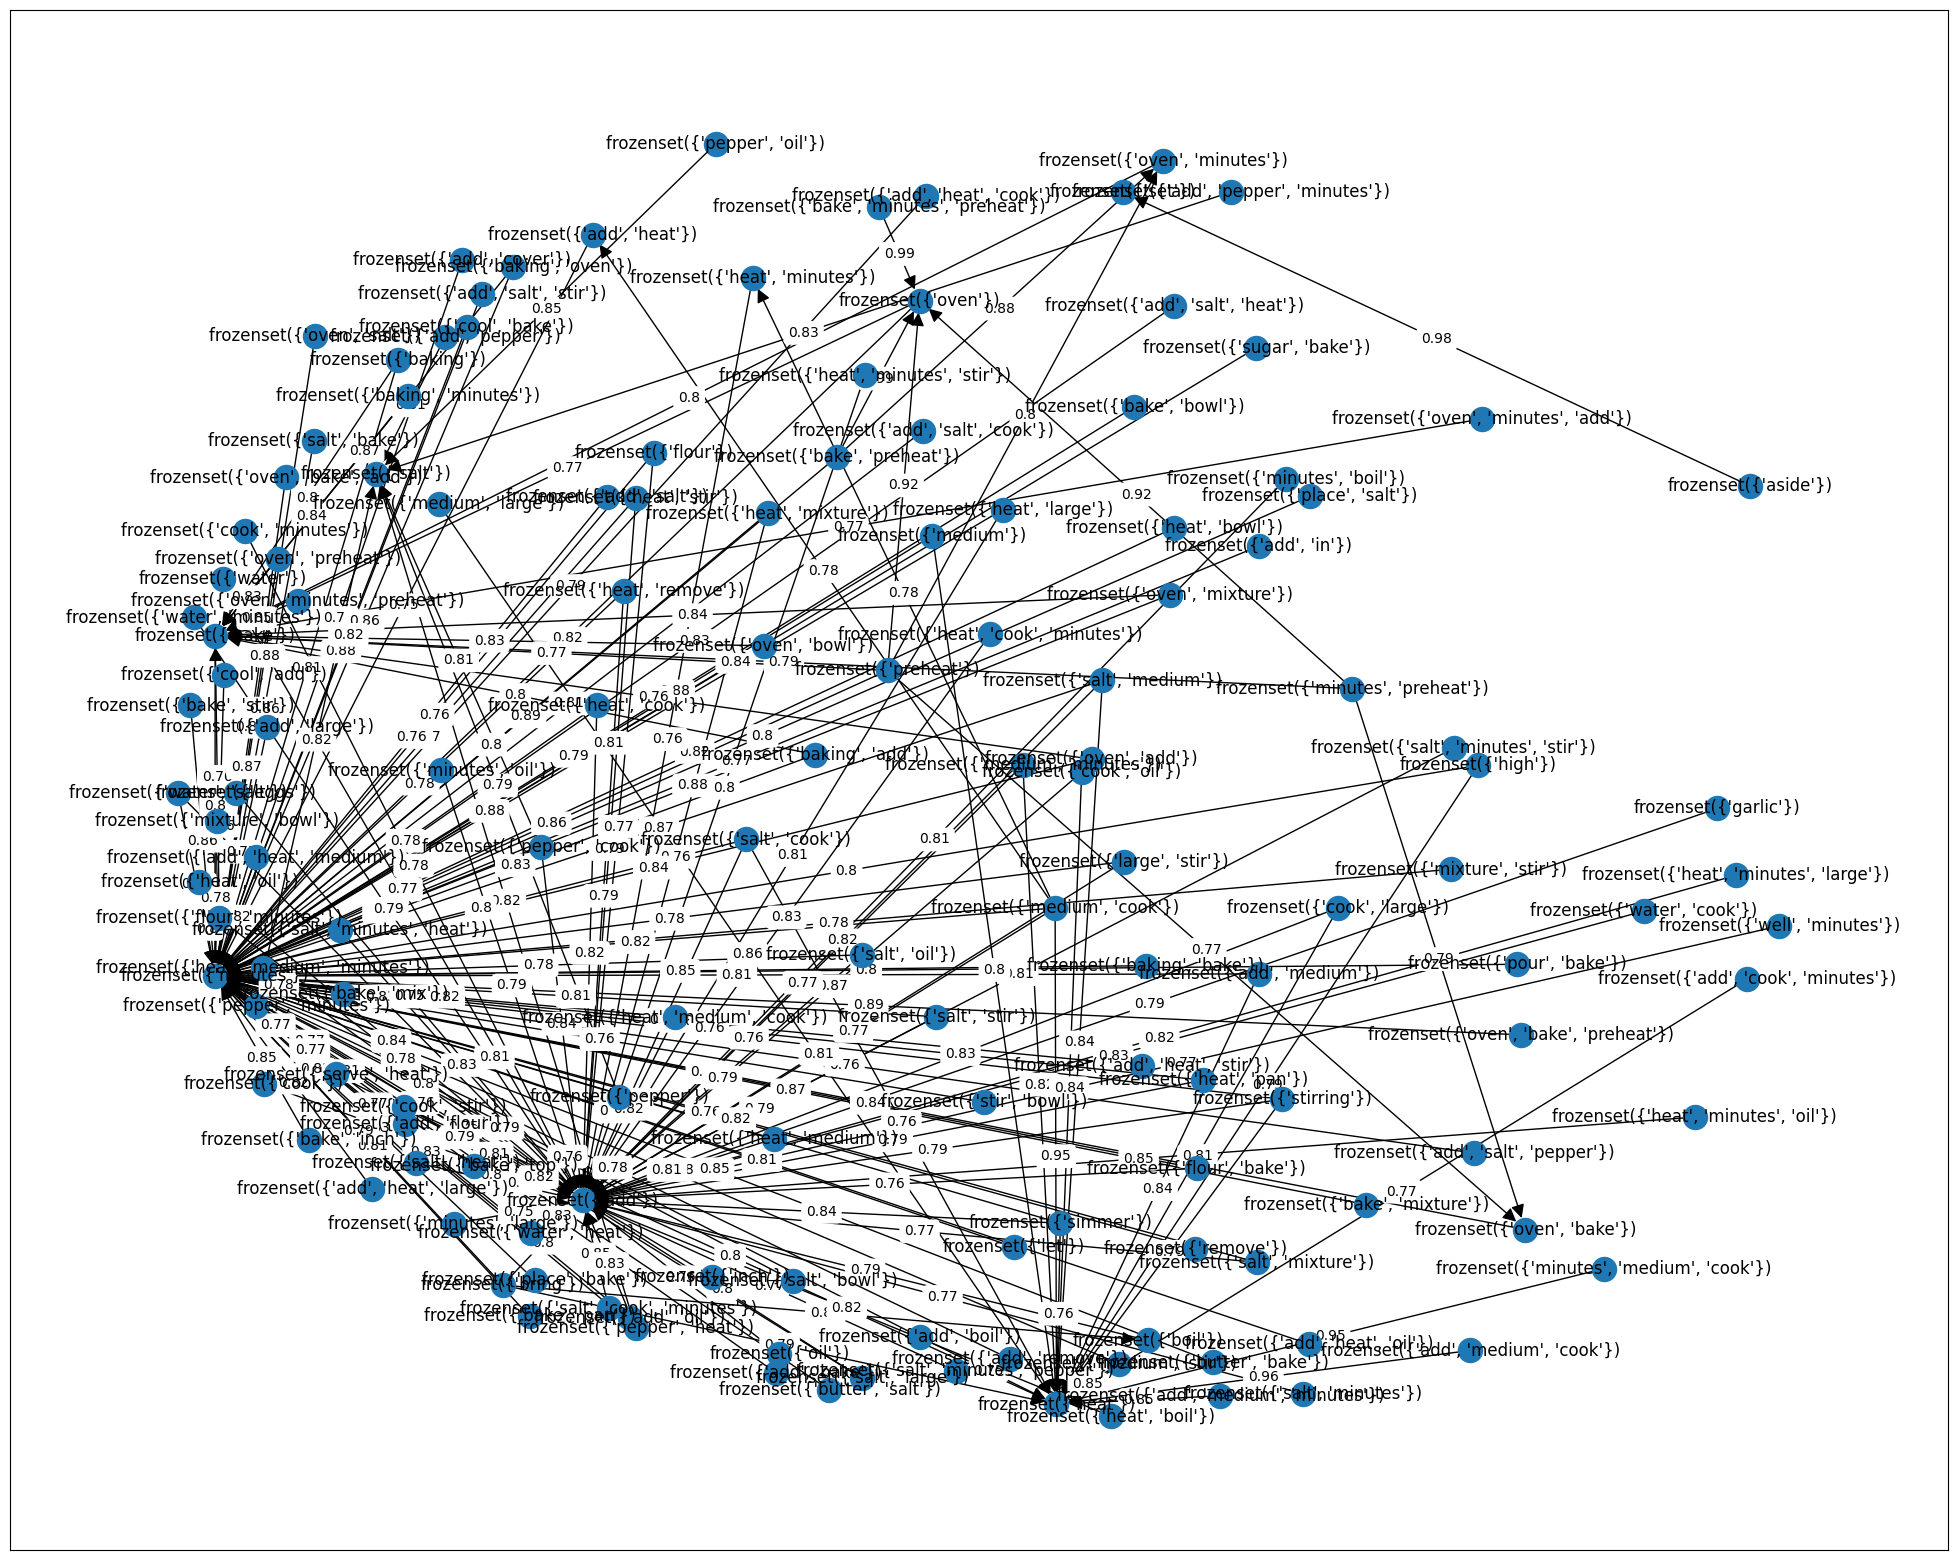

In [14]:
# Create a directed network graph of the association rules but this time using confidence as the edge weight.
# Also make the edges different color depending on how high the confidence is.

# Clear previous graph
G.clear()

# Only consider rules with confidence greater than X
filtered_rules = rules[rules.confidence >= 0.75]

# Create an edges list (antedecent, consequent, {'w': confidence})
edges = [ (filtered_rules.iloc[i]['antecedents'], filtered_rules.iloc[i]['consequents'], {'w': round(filtered_rules.iloc[i]['confidence'],2)}) for i in range(len(filtered_rules))]

G = nx.DiGraph()
G.add_edges_from(edges)
pos=nx.spring_layout(G,k=0.75)
fig, ax = plt.subplots(figsize=(25, 20))
nx.draw_networkx_nodes(G, pos, ax=ax)
nx.draw_networkx_labels(G, pos, ax=ax)
curved_edges = [edge for edge in G.edges() if reversed(edge) in G.edges()]
straight_edges = list(set(G.edges()) - set(curved_edges))
nx.draw_networkx_edges(G, pos, ax=ax, edgelist=straight_edges, arrowsize=20)
arc_rad = 0.1
nx.draw_networkx_edges(G, pos, ax=ax, edgelist=curved_edges, connectionstyle=f'arc3, rad = {arc_rad}', arrowsize=20)


edge_weights = nx.get_edge_attributes(G,'w')
curved_edge_labels = {edge: edge_weights[edge] for edge in curved_edges}
straight_edge_labels = {edge: edge_weights[edge] for edge in straight_edges}
my_draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=curved_edge_labels,rotate=False,rad = arc_rad)
nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=straight_edge_labels,rotate=False)
fig.savefig("3.png", bbox_inches='tight',pad_inches=0)

205
Adding node frozenset({'add', 'heat'})
Adding node frozenset({'minutes'})
Adding node frozenset({'heat', 'minutes'})
Adding node frozenset({'add'})
Adding node frozenset({'heat', 'stir'})
Adding node frozenset({'add', 'heat', 'stir'})
Adding node frozenset({'heat', 'minutes', 'stir'})
Adding node frozenset({'salt', 'stir'})
Adding node frozenset({'add', 'salt', 'stir'})
Adding node frozenset({'salt', 'minutes', 'stir'})
Adding node frozenset({'bake', 'stir'})
Adding node frozenset({'heat', 'mixture'})
Adding node frozenset({'mixture', 'stir'})
Adding node frozenset({'salt', 'mixture'})
Adding node frozenset({'mixture', 'bowl'})
Adding node frozenset({'bake', 'mixture'})
Adding node frozenset({'sugar', 'bake'})
Adding node frozenset({'bake', 'top'})
Adding node frozenset({'butter', 'salt'})
Adding node frozenset({'butter', 'bake'})
Adding node frozenset({'well', 'minutes'})
Adding node frozenset({'medium'})
Adding node frozenset({'heat'})
Adding node frozenset({'heat', 'medium'})
Ad

(-0.7679288459763116,
 1.1679932387579302,
 -0.9876520128159734,
 0.945025445449893)

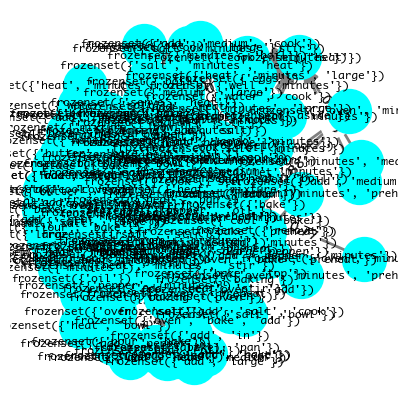

In [15]:
filtered_rules = rules[rules.confidence >= 0.75]
print(len(filtered_rules))
# Clear previous graph
G.clear()
G = nx.DiGraph()
for i in range(len(filtered_rules)):
    # if node does not exist then add it
    if not G.has_node(filtered_rules.iloc[i]['antecedents']):
        print(f'Adding node {filtered_rules.iloc[i]["antecedents"]}')
        G.add_node(filtered_rules.iloc[i]['antecedents'])
    if not G.has_node(filtered_rules.iloc[i]['consequents']):
        print(f'Adding node {filtered_rules.iloc[i]["consequents"]}')
        G.add_node(filtered_rules.iloc[i]['consequents'])
    # add edge with an arrow from antecedents to consequents
    G.add_edge(filtered_rules.iloc[i]['antecedents'], filtered_rules.iloc[i]['consequents'], weight=filtered_rules.iloc[i]['confidence'])

# make the graph bigger
plt.figure(figsize=(5, 5))
# Draw the network graph
pos = nx.spring_layout(G, k=0.5)
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color="cyan")
nx.draw_networkx_edges(G, pos, width=2, edge_color="gray", arrowsize=20)
nx.draw_networkx_labels(G, pos, font_size=8, font_family="Monaco")
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{w:.2f}" for u, v, w in G.edges(data="weight")})
plt.axis("off")
#plt.show()

In [16]:
# Apply page rank to the network graph
page_rank = nx.pagerank(G)
# Sort the recipes by page rank
sorted(page_rank.items(), key=lambda x: x[1], reverse=True)[:25]

[(frozenset({'minutes'}), 0.2487660102587465),
 (frozenset({'add'}), 0.1317447369306422),
 (frozenset({'heat'}), 0.03873622284331568),
 (frozenset({'bake'}), 0.035640563715609926),
 (frozenset({'salt'}), 0.01999154350310272),
 (frozenset({'oven'}), 0.009844112172399553),
 (frozenset({'set'}), 0.006845660104876608),
 (frozenset({'minutes', 'oven'}), 0.005314450552473204),
 (frozenset({'bake', 'oven'}), 0.005273087600309875),
 (frozenset({'boil'}), 0.0045407013052687515),
 (frozenset({'heat', 'minutes'}), 0.004293593441754079),
 (frozenset({'add', 'heat'}), 0.004292636298352305),
 (frozenset({'heat', 'stir'}), 0.0037001273379629715),
 (frozenset({'add', 'heat', 'stir'}), 0.0037001273379629715),
 (frozenset({'heat', 'minutes', 'stir'}), 0.0037001273379629715),
 (frozenset({'salt', 'stir'}), 0.0037001273379629715),
 (frozenset({'add', 'salt', 'stir'}), 0.0037001273379629715),
 (frozenset({'minutes', 'salt', 'stir'}), 0.0037001273379629715),
 (frozenset({'bake', 'stir'}), 0.0037001273379629

In [20]:
# Save to a file the neighbors and weights of the top 5 recipes by page rank
with open('dataset/rules_extracted_confidence.txt', 'w') as f:
    for recipe in sorted(page_rank.items(), key=lambda x: x[1], reverse=True)[:1]:
        print(recipe)
        f.write(f"Recipe: {recipe[0]}\n")
        # Find the most important 5 neighbors of the recipe
        print(G, G[recipe[0]])
        for node in G.nodes():
            if node == recipe[0]:
                print(node)
        

(frozenset({'minutes'}), 0.2487660102587465)
DiGraph with 143 nodes and 205 edges {}
frozenset({'minutes'})
